**《深度学习之 PyTorch 实战》**

讲师作者：[土豆老师](https://iphysresearch.github.io)

# 计算机视觉

近年来，深度学习一直是提高计算机视觉系统性能的变革力量。 无论是医疗诊断、自动驾驶车辆，还是智能滤镜、摄像头监控，许多计算机视觉领域的应用都与我们当前和未来的生活密切相关。 可以说，最先进的计算机视觉应用程序与深度学习几乎是不可分割的。 有鉴于此，本讲将重点介绍计算机视觉领域，并探讨最近在学术界和行业中具有影响力的方法和应用。


## 图像增广

>(Restart your kernel here)

在「深度卷积神经网络」里我们提到过，大规模数据集是成功应用深度神经网络的前提。

图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。

图像增广的另一种解释是，随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。可以说，在当年AlexNet的成功中，图像增广技术功不可没。

本节我们将讨论这个在计算机视觉里被广泛使用的技术。

首先，导入实验所需的包或模块。

In [1]:
%matplotlib inline
import sys
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import dl4wm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 常用的图像增广方法

我们来读取一张形状为 $400 \times 500$ (高和宽分别为400像素和500像素) 的图像作为实验的样例。

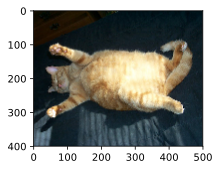

In [2]:
dl4wm.set_figsize()
img = Image.open('Datasets/img/cat1.jpg')
dl4wm.plt.imshow(img)

下面定义绘图函数 `show_images`。

In [3]:
# 本函数已保存在 dl4wm 包中方便以后使用
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = dl4wm.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

大部分图像增广方法都有一定的随机性。为了方便观察图像增广的效果，接下来我们定义一个辅助函数 `apply`。这个函数对输入图像 `img` 多次运行图像增广方法 `aug` 并展示所有的结果。

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

#### 翻转和裁剪

左右翻转图像通常不改变物体的类别。它是最早也是最广泛使用的一种图像增广方法。下面我们通过 `torchvision.transforms` 模块创建 `RandomHorizontalFlip` 实例来实现一半概率的图像水平（左右）翻转。

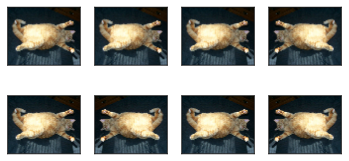

In [10]:
apply(img, torchvision.transforms.RandomHorizontalFlip(p=0.5))

上下翻转不如左右翻转通用。但是至少对于样例图像，上下翻转不会造成识别障碍。下面我们创建 `RandomVerticalFlip` 实例来实现一半概率的图像垂直（上下）翻转。

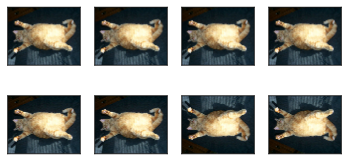

In [11]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在我们使用的样例图像里，猫在图像正中间，但一般情况下可能不是这样。在「池化层」节里我们解释了池化层能降低卷积层对目标位置的敏感度。除此之外，我们还可以通过对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性。

在下面的代码里，我们每次随机裁剪出一块面积为原面积 $10\% \sim 100 \%$ 的区域，且该区域的宽和高之比随机取自 $0.5 \sim 2$，然后再将该区域的宽和高分别缩放到 200 像素。若无特殊说明，本节中 $a$ 和 $b$ 之间的随机数指的是从区间 $[a, b]$ 中随机均匀采样所得到的连续值。

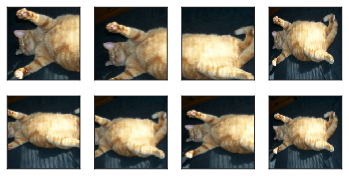

In [17]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

#### 变化颜色

另一类增广方法是变化颜色。我们可以从 4 个方面改变图像的颜色：亮度（ `brightness` ) 、对比度（ `contrast` ) 、饱和度 ( `saturation` ) 和色调 ( `hue` ) 。在下面的例子里，我们将图像的亮度随机变化为原图亮度的 $50\% (1-0.5) \sim 150 \%$ (1+ $0.5)$

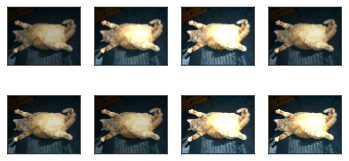

In [21]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

我们也可以随机变化图像的色调。

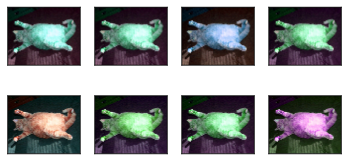

In [22]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

类似地，我们也可以随机变化图像的对比度。

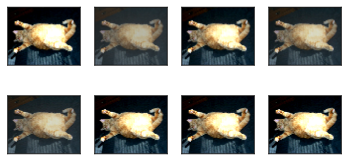

In [23]:
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

我们也可以同时设置如何随机变化图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）。

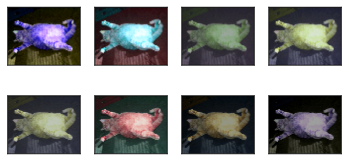

In [25]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

#### 叠加多个图像增广方法

实际应用中我们会将多个图像增广方法叠加使用。我们可以通过 `Compose` 实例将上面定义的多个图像增广方法叠加起来，再应用到每张图像之上。

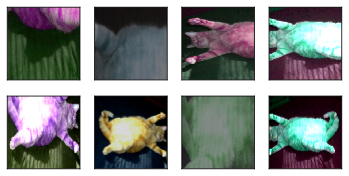

In [26]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

### 使用图像增广训练模型

下面我们来看一个将图像增广应用在实际训练中的例子。这里我们使用 CIFAR-10 数据集，而不是之前我们一直使用的 Fashion-MNIST 数据集。这是因为 Fashion-MNIST 数据集中物体的位置和尺寸都已经经过归一化处理，而 CIFAR-10 数据集中物体的颜色和大小区别更加显著。下面展示了 CIFAR-10 数据集中前 32 张训练图像。

Files already downloaded and verified


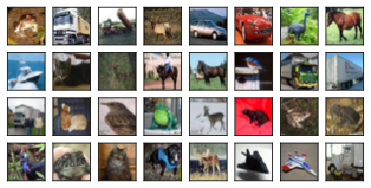

In [27]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="Datasets/CIFAR", download=True)
# all_imges的每一个元素都是(image, label)
show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);

# Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to Datasets/CIFAR/cifar-10-python.tar.gz

为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广。在这里我们只使用最简单的随机左右翻转。此外，我们使用 `ToTensor` 将小批量图像转成 PyTorch 需要的格式，即形状为(批量大小, 通道数, 高, 宽)、值域在 0 到 1 之间且类型为 32 位浮点数。

In [28]:
flip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

no_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

接下来我们定义一个辅助函数来方便读取图像并应用图像增广。有关 `DataLoader` 的详细介绍，可参考更早使用过的图像分类数据集(Fashion-MNIST)。

In [29]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="~/Datasets/CIFAR", train=is_train,
                                           transform=augs, download=True)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=num_workers)
    return dataloader

#### 使用图像增广训练模型

我们在 CIFAR-10 数据集上训练 5.11节（残差网络）中介绍的 ResNet-18 模型。

我们先定义 `train` 函数使用 GPU 训练并评价模型。



In [30]:
def train_batch_CV(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = dl4wm.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_CV(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=dl4wm.try_all_gpus()):
    """Train a model with mutiple GPUs (defined in Chapter 13)."""
    timer, num_batches = dl4wm.Timer(), len(train_iter)
    animator = dl4wm.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = dl4wm.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_CV(net, features, labels, loss, trainer,
                                      devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = dl4wm.evaluate_accuracy_gpus(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

然后就可以定义 `train_with_data_aug` 函数使用图像增广来训练模型了。该函数使用 Adam 算法作为训练使用的优化算法，然后将图像增广应用于训练数据集之上，最后调用刚才定义的 `train` 函数训练并评价模型。

In [31]:
batch_size, devices, net = 256, dl4wm.try_all_gpus(), dl4wm.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_CV(net, train_iter, test_iter, loss, trainer, 10, devices)

下面使用随机左右翻转的图像增广来训练模型。

loss 0.166, train acc 0.943, test acc 0.853
3123.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3)]


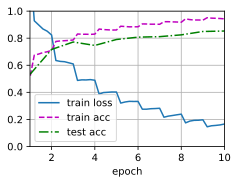

In [32]:
train_with_data_aug(flip_aug, no_aug, net)

### 小结


- 图像增广基于现有训练数据生成随机图像从而应对过拟合。
- 为了在预测时得到确定的结果，通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广。
- 可以从 `torchvision` 的 `transforms` 模块中获取有关图片增广的类。

## 微调

>(Restart your kernel here)

在前面的一些章节中，我们介绍了如何在只有 6 万张图像的 Fashion-MNIST 训练数据集上训练模型。我们还描述了学术界当下使用最广泛的大规模图像数据集 ImageNet，它有超过 1,000 万的图像和 1,000 类的物体。然而，我们平常接触到数据集的规模通常在这两者之间。

假设我们想从图像中识别出不同种类的椅子，然后将购买链接推荐给用户。一种可能的方法是先找出 100 种常见的椅子，为每种椅子拍摄 1,000 张不同角度的图像，然后在收集到的图像数据集上训练一个分类模型。这个椅子数据集虽然可能比 Fashion-MNIST 数据集要庞大，但样本数仍然不及ImageNet数据集中样本数的十分之一。这可能会导致适用于 ImageNet 数据集的复杂模型在这个椅子数据集上过拟合。同时，因为数据量有限，最终训练得到的模型的精度也可能达不到实用的要求。

为了应对上述问题，一个显而易见的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资金。例如，为了收集ImageNet数据集，研究人员花费了数百万美元的研究经费。虽然目前的数据采集成本已降低了不少，但其成本仍然不可忽略。

另外一种解决办法是应用迁移学习（transfer learning），将从源数据集学到的知识迁移到目标数据集上。例如，虽然ImageNet数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成等。这些类似的特征对于识别椅子也可能同样有效。

本节我们介绍迁移学习中的一种常用技术：**微调**（fine tuning）。如下图所示，微调由以下4步构成。

1. 在源数据集（如 ImageNet 数据集）上预训练一个神经网络模型，即源模型。
2. 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
3. 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
4. 在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。

![](Datasets/img/wYblhPIrUSKBJyG.png)

当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。

### 热狗识别

接下来我们来实践一个具体的例子：热狗识别。我们将基于一个小数据集对在 ImageNet 数据集上训练好的 ResNet 模型进行微调。该小数据集含有数千张包含热狗和不包含热狗的图像。我们将使用微调得到的模型来识别一张图像中是否包含热狗。

首先，导入实验所需的包或模块。torchvision 的 `models` 包提供了常用的预训练模型。如果希望获取更多的预训练模型，可以使用使用 `pretrained-models.pytorch` 仓库。

In [2]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os

import dl4wm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### 获取数据集

我们使用的热狗数据集（[点击下载](https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/hotdog.zip)）是从网上抓取的，它含有 1400 张包含热狗的正类图像，和同样多包含其他食品的负类图像。各类的 1000 张图像被用于训练，其余则用于测试。

我们首先将压缩后的数据集下载到路径 `data_dir` 之下，然后在该路径将下载好的数据集解压，得到两个文件夹 `hotdog/train` 和 `hotdog/test`。这两个文件夹下面均有 `hotdog` 和 `not-hotdog` 两个类别文件夹，每个类别文件夹里面是图像文件。

In [3]:
data_dir = 'Datasets/hotdog'
os.listdir(data_dir) # ['train', 'test']

['train', 'test']

我们创建两个 `ImageFolder` 实例来分别读取训练数据集和测试数据集中的所有图像文件。

In [4]:
train_imgs = ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'test'))

下面画出前 8 张正类图像和最后 8 张负类图像。可以看到，它们的大小和高宽比各不相同。

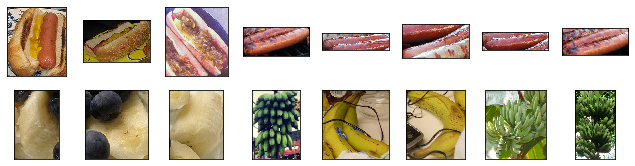

In [5]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
dl4wm.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

在训练时，我们先从图像中裁剪出随机大小和随机高宽比的一块随机区域，然后将该区域缩放为高和宽均为 224 像素的输入。测试时，我们将图像的高和宽均缩放为 256 像素，然后从中裁剪出高和宽均为 224 像素的中心区域作为输入。此外，我们对 RGB（红、绿、蓝）三个颜色通道的数值做标准化：每个数值减去该通道所有数值的平均值，再除以该通道所有数值的标准差作为输出。

>注: 在使用预训练模型时，一定要和预训练时作同样的预处理。 如果你使用的是 `torchvision` 的 `models`，那就要求: All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 如果你使用的是 [pretrained-models.pytorch](https://github.com/Cadene/pretrained-models.pytorch) 仓库，请务必阅读其README，其中说明了如何预处理。

In [6]:
# 指定RGB三个通道的均值和方差来将图像通道归一化
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])

#### 定义和初始化模型

我们使用在 ImageNet 数据集上预训练的 ResNet-18 作为源模型。这里指定 `pretrained=True` 来自动下载并加载预训练的模型参数。在第一次使用时需要联网下载模型参数。

>不管你是使用的 `torchvision` 的 `models` 还是 `pretrained-models.pytorch` 仓库，默认都会将预训练好的模型参数下载到你的 home 目录下 `.cache/torch/checkpoints` 文件夹。你可以通过修改环境变量 `$TORCH_MODEL_ZOO` 来更改下载目录:
>
>```shell
export TORCH_MODEL_ZOO="/local/pretrainedmodels
>```
>
>另外我们比较常使用的方法是，在其源码中找到下载地址直接浏览器输入地址下载，下载好后将其放到环境变量 `$TORCH_MODEL_ZOO` 所指文件夹即可，这样比较快。

In [7]:
pretrained_net = models.resnet18(pretrained=True)

# Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth

下面打印源模型的成员变量 `fc`。作为一个全连接层，它将 ResNet 最终的全局平均池化层输出变换成 ImageNet 数据集上 1000 类的输出。

In [8]:
print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)


>注: 如果你使用的是其他模型，那可能没有成员变量 `fc`（比如 models 中的 VGG 预训练模型），所以正确做法是查看对应模型源码中其定义部分，这样既不会出错也能加深我们对模型的理解。[pretrained-models.pytorch](https://github.com/Cadene/pretrained-models.pytorch) 仓库貌似统一了接口，但是我还是建议使用时查看一下对应模型的源码。

可见此时 `pretrained_net` 最后的输出个数等于目标数据集的类别数 1000。所以我们应该将最后的 `fc` 成修改我们需要的输出类别数:

In [9]:
pretrained_net.fc = nn.Linear(512, 2)
print(pretrained_net.fc)

Linear(in_features=512, out_features=2, bias=True)


此时，`pretrained_net` 的 `fc` 层就被随机初始化了，但是其他层依然保存着预训练得到的参数。由于是在很大的 ImageNet 数据集上预训练的，所以参数已经足够好，因此一般只需使用较小的学习率来微调这些参数，而 `fc` 中的随机初始化参数一般需要更大的学习率从头训练。PyTorch 可以方便的对模型的不同部分设置不同的学习参数，我们在下面代码中将 `fc` 的学习率设为已经预训练过的部分的 10 倍。

In [10]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

#### 微调模型

我们先定义一个使用微调的训练函数 `train_fine_tuning` 以便多次调用。

In [11]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                         transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                         transform=test_augs),
        batch_size=batch_size)
    devices = dl4wm.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [
            param for name, param in net.named_parameters()
            if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{
            'params': params_1x}, {
                'params': net.fc.parameters(),
                'lr': learning_rate * 10}], lr=learning_rate,
                                  weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    dl4wm.train_CV(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

我们将基本学习率设置较小，通过微调预训练获得的模型参数。

loss 0.487, train acc 0.862, test acc 0.931
607.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3)]


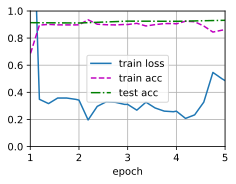

In [12]:
train_fine_tuning(finetune_net, 5e-5)

作为对比，我们定义一个相同的模型，但将它的所有模型参数都初始化为随机值。由于整个模型都需要从头训练，我们可以使用较大的学习率。

loss 0.364, train acc 0.843, test acc 0.863
1270.2 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3)]


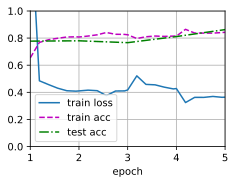

In [13]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

可以看到，微调的模型因为参数初始值更好，往往在相同迭代周期下取得更高的精度。

### 小结

- 迁移学习将从源数据集学到的知识迁移到目标数据集上。微调是迁移学习的一种常用技术。
- 目标模型复制了源模型上除了输出层外的所有模型设计及其参数，并基于目标数据集微调这些参数。而目标模型的输出层需要从头训练。
- 一般来说，微调参数会使用较小的学习率，而从头训练输出层可以使用较大的学习率。